In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import acquire as aq
import prepare as pr
import explore as ex


from itertools import combinations
from scipy import stats
from scipy.stats import pearsonr, spearmanr

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

warnings.filterwarnings('ignore')

---

## Aquisition and Preparing the data

In [2]:
df = aq.get_zillow_data()

In [3]:
df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,yearbuilt,taxamount,taxvaluedollarcnt,fips
0,0.0,0.0,NaN,NaN,NaN,27516.0,6037.0
1,0.0,0.0,NaN,NaN,NaN,10.0,6037.0
2,0.0,0.0,NaN,NaN,NaN,10.0,6037.0
3,0.0,0.0,NaN,NaN,174.21,2108.0,6037.0
4,2.0,4.0,3633.0,2005.0,6941.39,296425.0,6037.0


In [4]:
df.shape

(2152863, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152863 entries, 0 to 2152862
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bathroomcnt                   float64
 1   bedroomcnt                    float64
 2   calculatedfinishedsquarefeet  float64
 3   yearbuilt                     float64
 4   taxamount                     float64
 5   taxvaluedollarcnt             float64
 6   fips                          float64
dtypes: float64(7)
memory usage: 115.0 MB


In [6]:
# Nulls located in many of the columns. Im the prepare.py prep function, 
# those are dropped while maintaining integrity of the dataset

zillow = pr.prep_zillow_initial(df)

### Sample and Summarize

In [7]:
zillow.head()

,bathrooms,bedrooms,sqft,year_built,tax_amount,tax_value,fips
7,2.0,3.0,2077.0,1926.0,7924.68,646760.0,Los Angeles
18,1.0,3.0,1244.0,1950.0,2532.88,169471.0,Los Angeles
19,2.0,3.0,1300.0,1950.0,3110.99,233266.0,Los Angeles
20,2.0,3.0,1222.0,1951.0,3870.25,290492.0,Los Angeles
40,1.0,2.0,725.0,1953.0,576.47,37548.0,Los Angeles


In [8]:
zillow.shape

(1807580, 7)

In [9]:
# reading summary statistics for numeric columns
zillow.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,1807580.0,2.061820,0.701157,1.00,2.00,2.00,2.50,4.0
bedrooms,1807580.0,3.219763,0.777754,2.00,3.00,3.00,4.00,5.0
sqft,1807580.0,1654.103315,562.374368,1.00,1233.00,1549.00,1986.00,3408.0
year_built,1807580.0,1960.145188,19.092832,1914.00,1950.00,1957.00,1972.00,2008.0
tax_amount,1807580.0,4071.853164,2235.776842,16.48,2377.49,3754.54,5481.82,11008.3
tax_value,1807580.0,327663.649578,196980.739450,22.00,174462.00,297510.00,452269.50,882680.0


In [10]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1807580 entries, 7 to 2152853
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   bathrooms   float64
 1   bedrooms    float64
 2   sqft        float64
 3   year_built  float64
 4   tax_amount  float64
 5   tax_value   float64
 6   fips        object 
dtypes: float64(6), object(1)
memory usage: 110.3+ MB


### Acquire and Summarize Takeaways:
- Null values have been dropped, removing about 220k homes from the dataset
- As fips represents the county/state that the homes are located, the distinct numerical values (3) were changed to categorical columns that visually represent their counties.
- Column naming conventions were changed for more readable and recognizable content
- Bedroms and bathroom outliers were changed where bedrooms or bathrooms would equal 0, as these are not representitive of a family home as outlined : [CHAPTER 96. - SINGLE- AND MULTI-FAMILY HOUSING CODE, of the Code of Ordinances](https://library.municode.com/tx/carrollton/codes/code_of_ordinances?nodeId=TITIXHESAPRMA_CH96SIULMIHOCO)

---

## Visualizing Distributions of data in samples
- Samples are required to visualize datapoints as the entire dataset is too large to fit into a proper graphic.

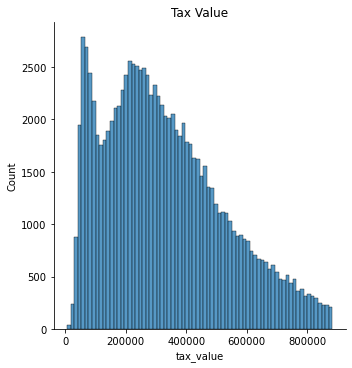

In [11]:
# displot of the target variable
sns.displot(x='tax_value', data=zillow.sample(100_000))
plt.title('Tax Value')
plt.show()

### Takeaways:
- Distribution of the target variable is positively skewed.

##### Now plotting each numeric column of interest and showing the distribution on a separate subplot.


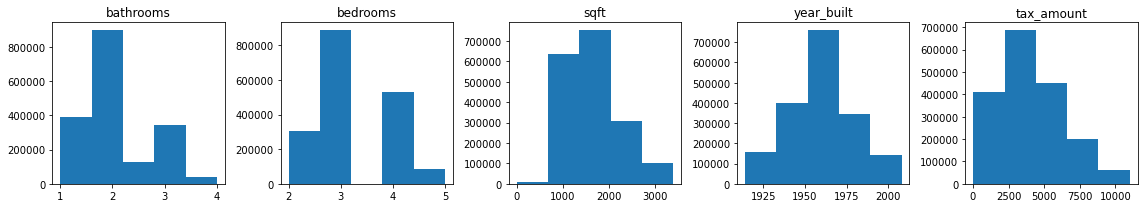

In [12]:
plt.figure(figsize=(16,3))

# list of columns 
cols = ['bathrooms', 'bedrooms', 'sqft', 'year_built', 'tax_amount']

for i, col in enumerate(cols):
    
    # i starts at 0 but plot sums should start at 1
    plot_number = i + 1
    
    # create subplot
    plt.subplot(1,5, plot_number)
    
    #title with each col name
    plt.title(col)
    
    # display hist for each column
    zillow[col].hist(bins=5)
    
    # hide gridlines
    plt.grid(False)
    plt.tight_layout()

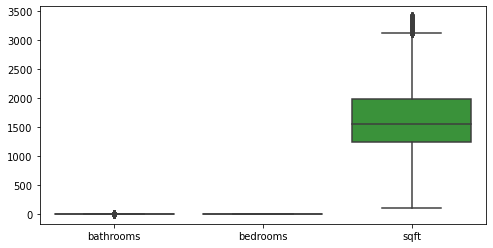

In [13]:
# creating boxplot for all numeric values
plt.figure(figsize=(8,4))

sns.boxplot(data=zillow.sample(100_000).drop(columns=['tax_value', 'tax_amount', 
                                                      'year_built']))
plt.show()

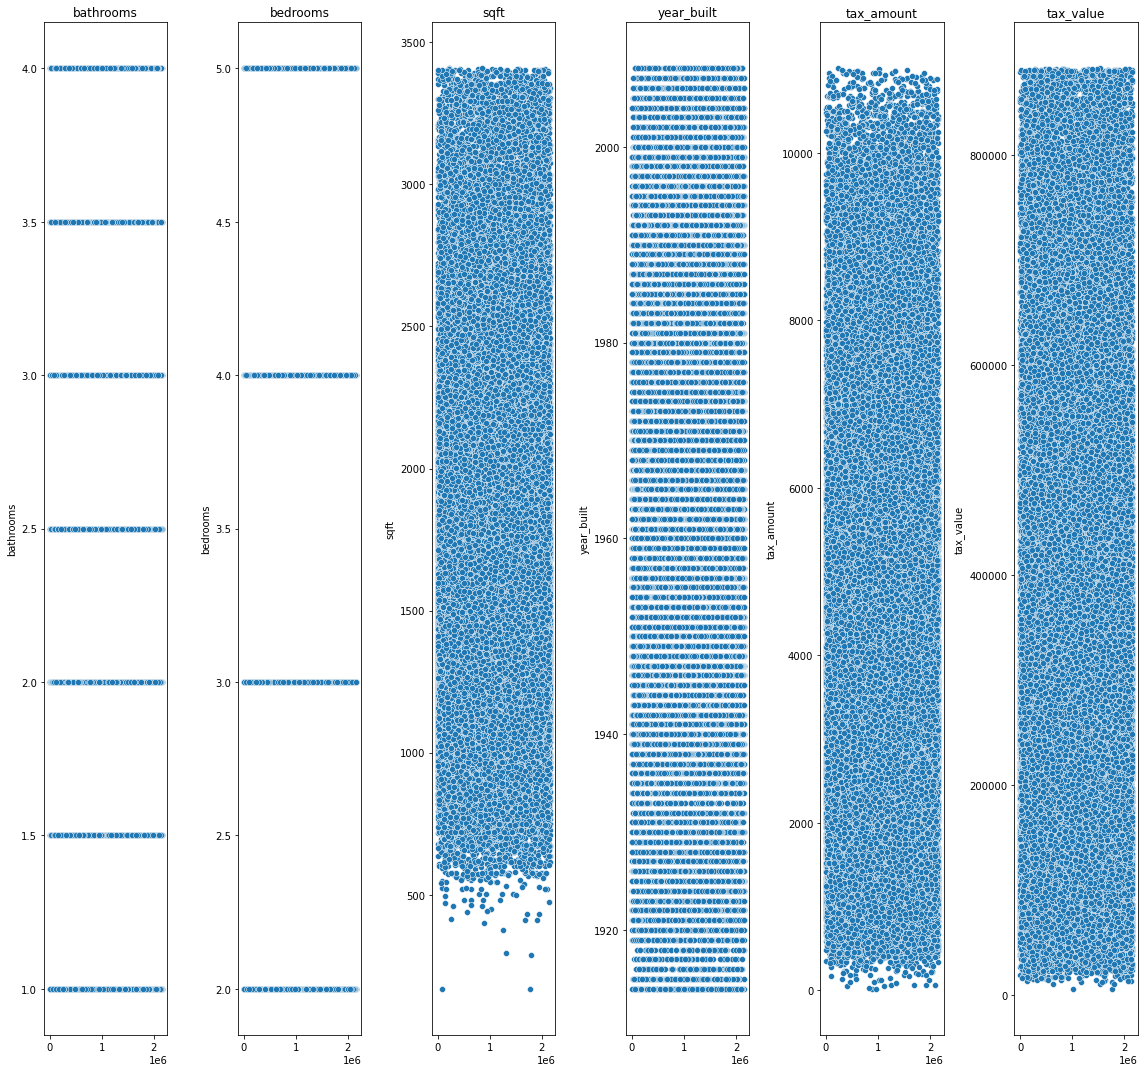

In [14]:
plt.figure(figsize=(16, 15))

# List of columns
cols = [col for col in zillow.columns if col not in ['fips']]
for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display scatterplot for column.
    sns.scatterplot(data=zillow.sample(100_000)[col])

    # Hide gridlines.
    plt.grid(False)
    plt.tight_layout()


### Takeaways:
- Most of the features are pretty normally distributed, except for tax_amount which is right/positive skewed.
- The boxplot tells me absolutely nothing of interest.
- Tax value and tax amount are almost identical. This is potential leak of information about the tax value, thus should be removed from this dataset.

---


### Exploration of the data :
- to begin with exploring the data, I have to split the data.

### Splitting the data:

In [15]:
train, validate, test = pr.prep_zillow(df)

In [16]:
train.shape, validate.shape, test.shape

((1012244, 7), (433820, 7), (361516, 7))

In [17]:
train.head()

,bathrooms,bedrooms,sqft,year_built,tax_amount,tax_value,fips
1443537,2.0,3.0,1205.0,1964.0,5447.96,466000.0,Ventura County
1522127,1.0,2.0,884.0,1926.0,1841.11,137911.0,Los Angeles
1808029,2.5,3.0,1734.0,1997.0,8587.12,578692.0,Orange County
1542071,3.0,4.0,2008.0,1980.0,5344.68,402623.0,Los Angeles
2032879,3.0,4.0,2270.0,1965.0,7441.18,686554.0,Orange County


In [18]:
# understanding the data
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1012244 entries, 1443537 to 603901
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   bathrooms   1012244 non-null  float64
 1   bedrooms    1012244 non-null  float64
 2   sqft        1012244 non-null  float64
 3   year_built  1012244 non-null  float64
 4   tax_amount  1012244 non-null  float64
 5   tax_value   1012244 non-null  float64
 6   fips        1012244 non-null  object 
dtypes: float64(6), object(1)
memory usage: 61.8+ MB


In [19]:
# describing the data
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,1012244.0,2.061263,0.700953,1.00,2.0000,2.00,2.5000,4.00
bedrooms,1012244.0,3.220033,0.777317,2.00,3.0000,3.00,4.0000,5.00
sqft,1012244.0,1653.939508,562.184878,1.00,1233.0000,1549.00,1986.0000,3408.00
year_built,1012244.0,1960.124984,19.060670,1914.00,1950.0000,1957.00,1972.0000,2008.00
tax_amount,1012244.0,4071.678735,2237.246554,16.48,2374.6775,3754.54,5482.9425,11008.22
tax_value,1012244.0,327710.289966,197068.992490,22.00,174378.5000,297619.00,452500.0000,882680.00


### Asking the question : What are the attributes and drivers of home value? 
- Let's first visualize a heatmap

In [20]:
train_corr = train.drop(columns=['fips']).corr()

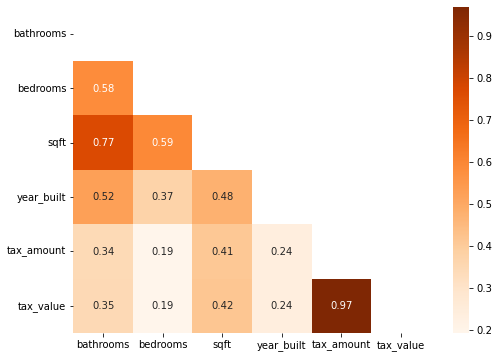

In [21]:
plt.figure(figsize=(8,6))
sns.heatmap(train_corr, cmap='Oranges', annot=True, mask=np.triu(train_corr))
plt.show()

### Heatmap Takeaway : 
- sqaurefoot 'sqft' has the highest correlation with tax value amount (.42)
- The tax amount and tax value do have such a high correlation, however the tax amount is a feature of tax value and thus won't be used as a driver of home value. 


### A look at each attributed paired against one another : 

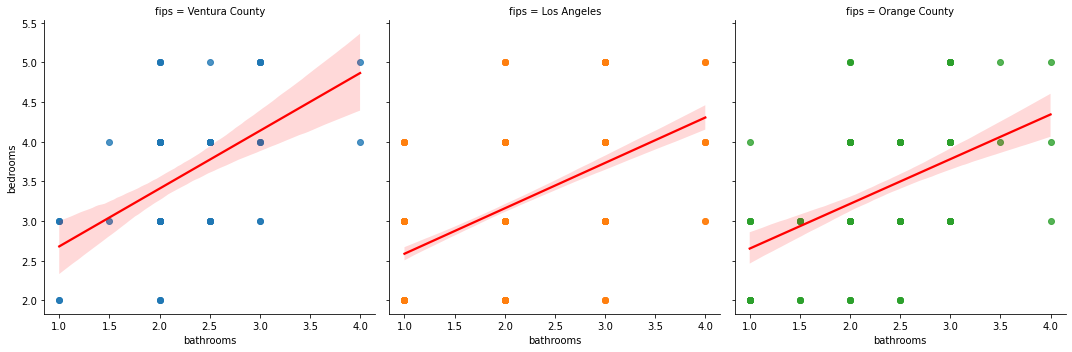

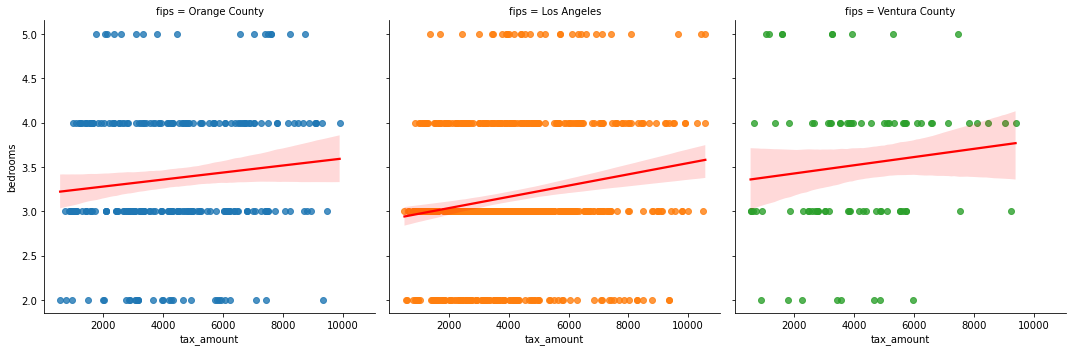

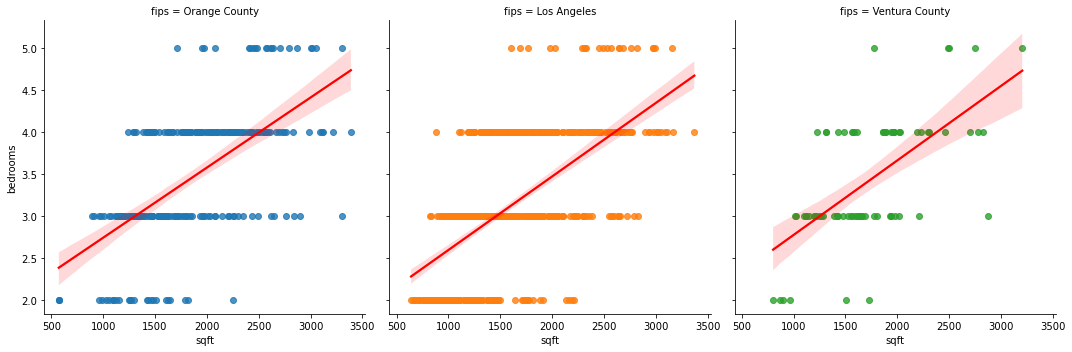

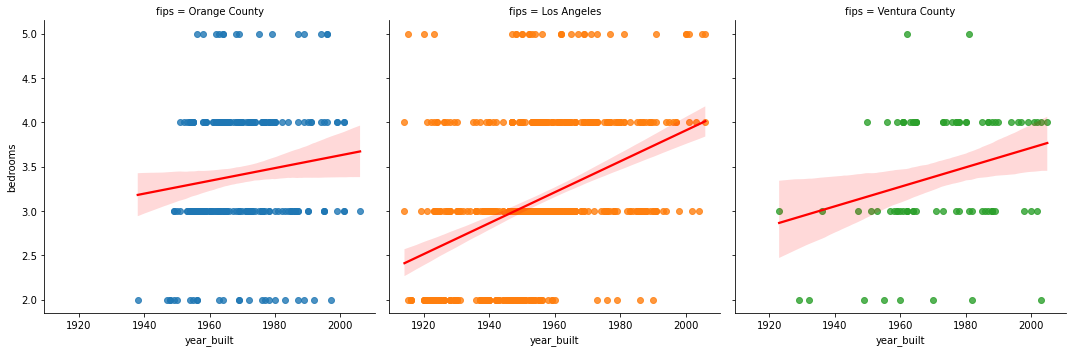

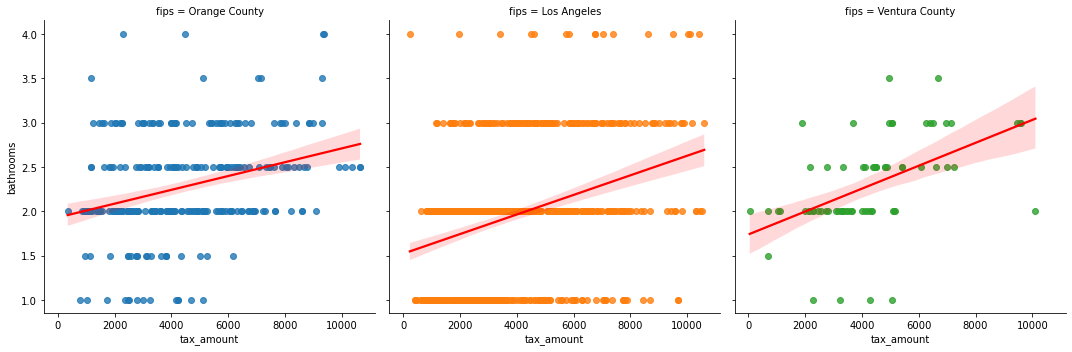

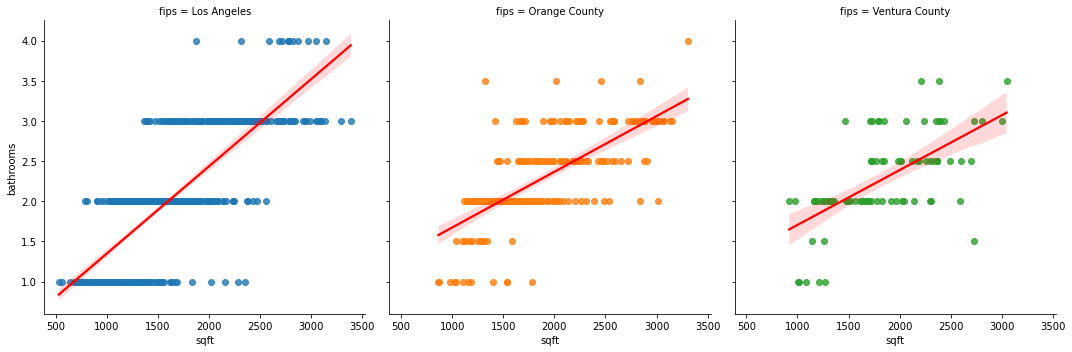

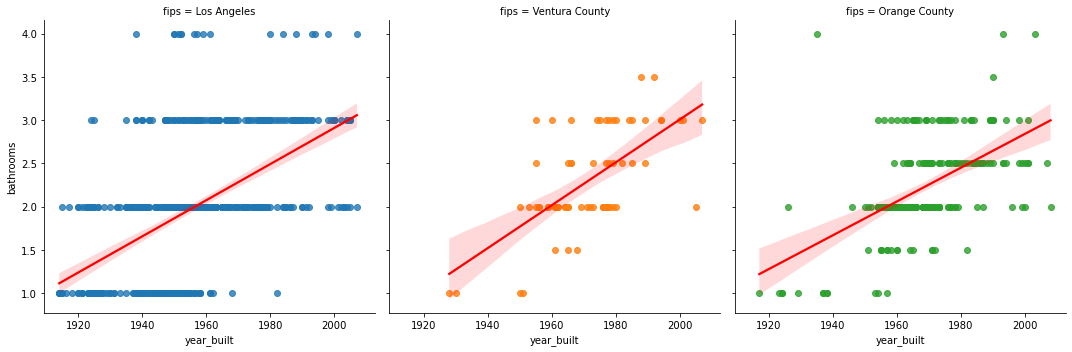

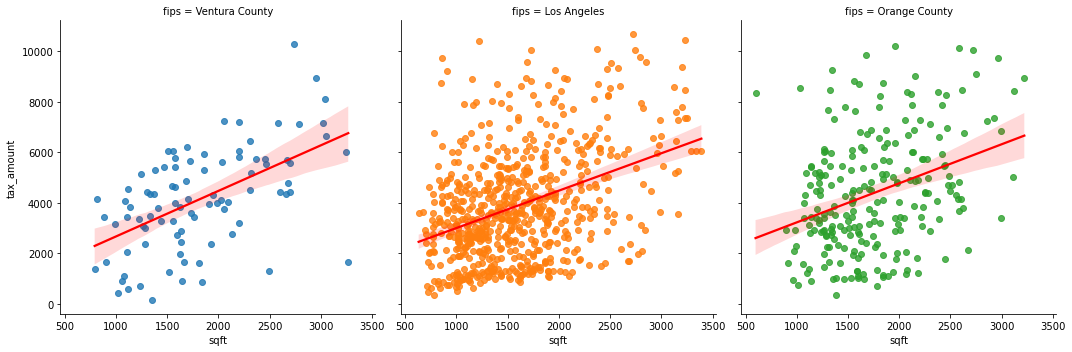

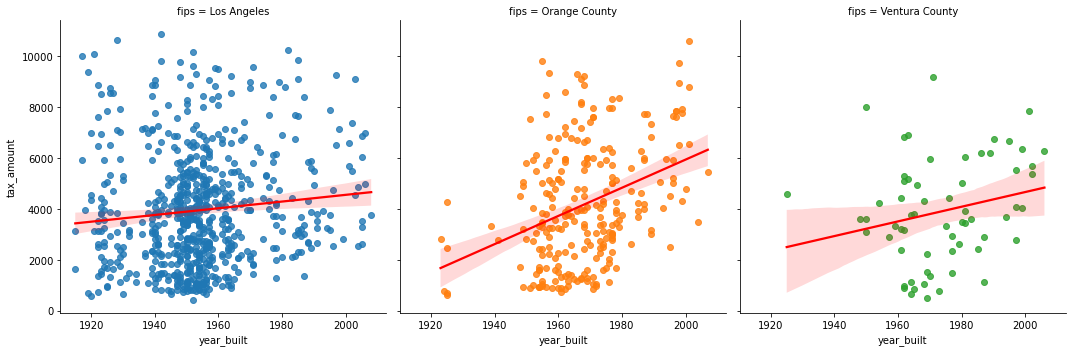

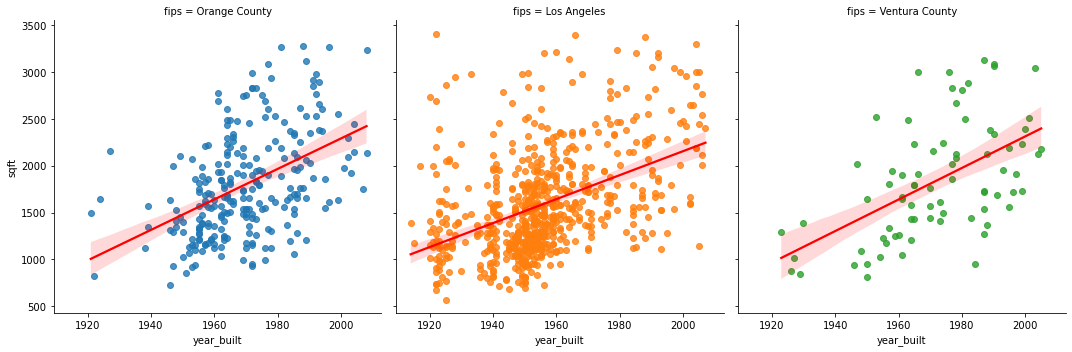

In [22]:
ex.plot_variable_pairs(train)

### Now, let's take a look at sqft and tax_value per county

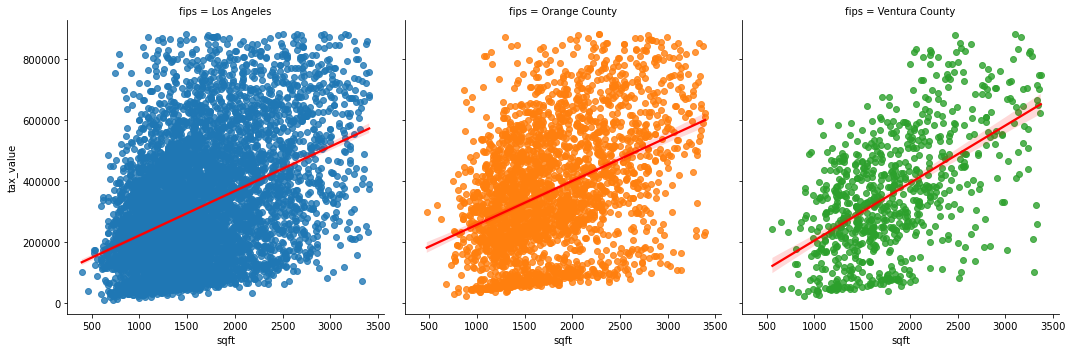

In [23]:
    column = ['tax_value', 'sqft']
    
    columns= combinations(column, 2)
    
    for col in columns:
        sns.lmplot(data = train.sample(10_000), x=col[1] , y=col[0],
                   col = 'fips',
                   hue='fips',line_kws={'color': 'red'} )

### Hypothesis Testing : Pearson R and T-Test

- ${H_0}$ : My null hypothesis is that there is no correlation between sqare-feet and tax value and that they are independent. 
- ${H_a}$ : My alternative hypothesis is that there is some correlation as they are dependent. 

In [24]:
r, p = pearsonr(train.sqft, train.tax_value)
print(f'Correlation between Coefficient: {r}\nP :{p}')

Correlation between Coefficient: 0.4168569713944085
P :0.0


In [25]:
# set alpha
alpha = 0.05

t, p = stats.ttest_ind(train.tax_value, train.sqft, equal_var=False)
t, p / 2

(1664.6203721530712, 0.0)

In [26]:
if p / 2 > alpha:
    print("We fail to reject the null hypothesis that there is no correlation and that they are independent")
elif t < 0:
    print("We fail to reject the null hypothesis that there is no correlation and that they are independent")
else:
    print("We reject the null hypothesis that there is no correlation and that they are independent")

We reject the null hypothesis that there is no correlation and that they are independent


### Takeaways:
- There appears to be a relationship between a homes sqaure feet and it's tax/home value. 

### Questions to ask #2: 
- Why do properties have a much higher value than others when they are located so close to one another? 
- Is location a stronger driver in deciding home value than other features? 


Being close to one another assumes they are in the same county. So first, let's look at each county : 

In [27]:
train.fips.value_counts()

Los Angeles       674438
Orange County     257806
Ventura County     80000
Name: fips, dtype: int64

In [28]:
la_data = train[train.fips == 'Los Angeles']
orangecounty_data = train[train.fips == 'Orange County']
ventura_data = train[train.fips == 'Ventura County']

In [29]:
la_data.shape, orangecounty_data.shape, ventura_data.shape

((674438, 7), (257806, 7), (80000, 7))

### Let's look at a heatmap of each county

In [30]:
la_corr = la_data.corr()
orangecounty_corr = orangecounty_data.corr()
ventura_corr = ventura_data.corr()

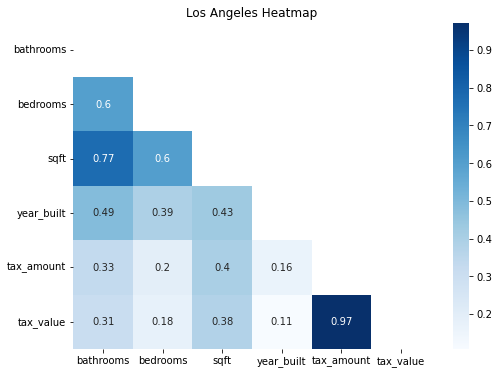

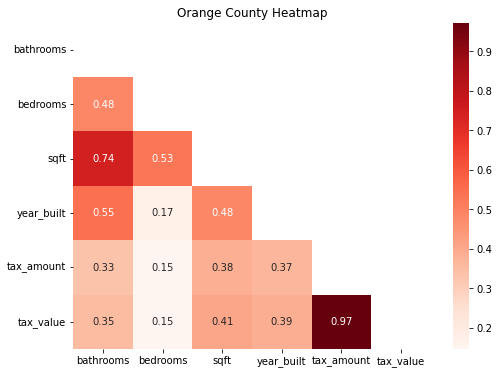

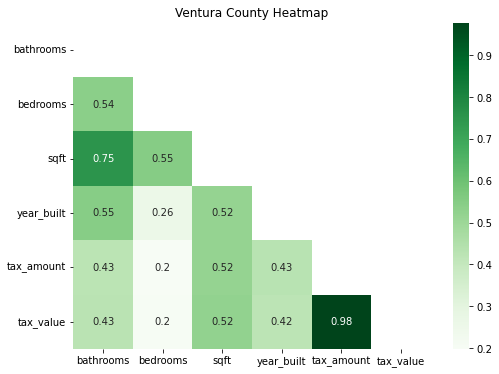

In [31]:
plt.figure(figsize=(8,6))
sns.heatmap(la_corr, cmap='Blues', annot=True, mask=np.triu(train_corr))
plt.title('Los Angeles Heatmap')
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(orangecounty_corr, cmap='Reds', annot=True, mask=np.triu(train_corr))
plt.title('Orange County Heatmap')
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(ventura_corr, cmap='Greens', annot=True, mask=np.triu(train_corr))
plt.title('Ventura County Heatmap')
plt.show()

### Los Angeles : 
- Why do properties have a much higher value than others when they are located so close to one another? 

In [32]:
la_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 674438 entries, 1522127 to 603901
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   bathrooms   674438 non-null  float64
 1   bedrooms    674438 non-null  float64
 2   sqft        674438 non-null  float64
 3   year_built  674438 non-null  float64
 4   tax_amount  674438 non-null  float64
 5   tax_value   674438 non-null  float64
 6   fips        674438 non-null  object 
dtypes: float64(6), object(1)
memory usage: 41.2+ MB


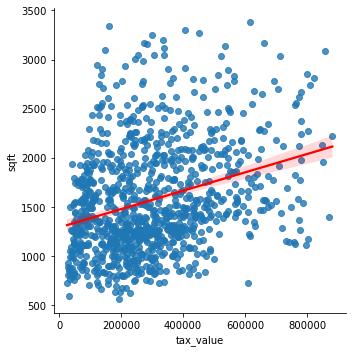

In [34]:
sns.lmplot(x='tax_value', y='sqft', data = la_data.sample(1000), line_kws={'color': 'red'})
plt.show()